In [1]:
import numpy as np
import tensorflow as tf
import random as python_random
np.random.seed(22)
python_random.seed(22)
tf.random.set_seed(22)

import pandas as pd
import warnings
import keras
from keras import backend as K
import numpy as np
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

from preprocessing import *

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 120

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

#filtrado de warnings
warnings.filterwarnings('ignore')

In [2]:
noticias_online_train_df = pd.read_parquet('train').set_index('url')
noticias_online_test_df = pd.read_parquet('test').set_index('url')

In [3]:
noticias_online_train_orden_df = noticias_online_train_df.sort_values('timedelta', ascending=False)
noticias_online_target_orden_df = noticias_online_train_orden_df.popular
noticias_online_train_orden_df = noticias_online_train_orden_df.drop(columns=['popular', 'shares'])

noticias_online_target_test_df = noticias_online_test_df.popular
noticias_online_test_df = noticias_online_test_df.drop(columns=['popular', 'shares'])

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(noticias_online_train_orden_df, noticias_online_target_orden_df, 0.4)

# Mean imputer, robust scaler, one hot encoding, mean encoding con smoothing y TF-IDF encoding

## Encoders y preprocesado de X_train, X_val, Y_train, Y_val y train

In [5]:
noticias_online_train_tf_idf, noticias_online_val_tf_idf, noticias_online_test_tf_idf = preprocessing_mean_imputer_robust_escaler_one_hot_encoding_mean_encoding_smooth_tf_idf_vectorizer(
    X_train,
    X_val,
    Y_train,
    noticias_online_test_df,
    True
    )

noticias_online_train_target_enc = Y_train.map({False: 0, True: 1})
noticias_online_val_target_enc = Y_val.map({False: 0, True: 1})
noticias_online_target_test_enc = noticias_online_target_test_df.map({False: 0, True: 1})

## Entreno la red

In [6]:
modelo = Sequential()
modelo.add(Dense(16, input_shape=(74,), activation='tanh'))
modelo.add(Dense(8, activation='tanh'))
modelo.add(Dense(4, activation='tanh'))
modelo.add(Dense(1, activation="sigmoid"))

In [7]:
opt = keras.optimizers.Adam(lr=0.0001)
modelo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1200      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________


In [8]:
historia = modelo.fit(
    noticias_online_train_tf_idf.values, noticias_online_train_target_enc.values, epochs=60, batch_size=256, validation_data=(noticias_online_val_tf_idf.values, noticias_online_val_target_enc.values)
)

Epoch 1/60
84/84 [==============================] - 1s 3ms/step - loss: 0.8066 - auc: 0.5179 - val_loss: 0.7040 - val_auc: 0.5151
Epoch 2/60
84/84 [==============================] - 0s 965us/step - loss: 0.7102 - auc: 0.5189 - val_loss: 0.6308 - val_auc: 0.5121
Epoch 3/60
84/84 [==============================] - 0s 989us/step - loss: 0.6391 - auc: 0.5224 - val_loss: 0.5805 - val_auc: 0.5092
Epoch 4/60
84/84 [==============================] - 0s 1ms/step - loss: 0.5912 - auc: 0.5244 - val_loss: 0.5487 - val_auc: 0.5082
Epoch 5/60
84/84 [==============================] - 0s 989us/step - loss: 0.5607 - auc: 0.5278 - val_loss: 0.5286 - val_auc: 0.5097
Epoch 6/60
84/84 [==============================] - 0s 977us/step - loss: 0.5416 - auc: 0.5346 - val_loss: 0.5157 - val_auc: 0.5146
Epoch 7/60
84/84 [==============================] - 0s 977us/step - loss: 0.5296 - auc: 0.5372 - val_loss: 0.5070 - val_auc: 0.5196
Epoch 8/60
84/84 [==============================] - 0s 977us/step - loss: 0.5218

## Evaluo la red (con validación)

In [9]:
scores = modelo.evaluate(noticias_online_val_tf_idf, noticias_online_val_target_enc)

446/446 [==============================] - 0s 454us/step - loss: 0.4610 - auc: 0.6795


In [10]:
auc = f'La {modelo.metrics_names[1]} es: {round(scores[1], 4)}'
auc

'La auc es: 0.6795'

## Veo cómo fue el score de AUC en validacion y training

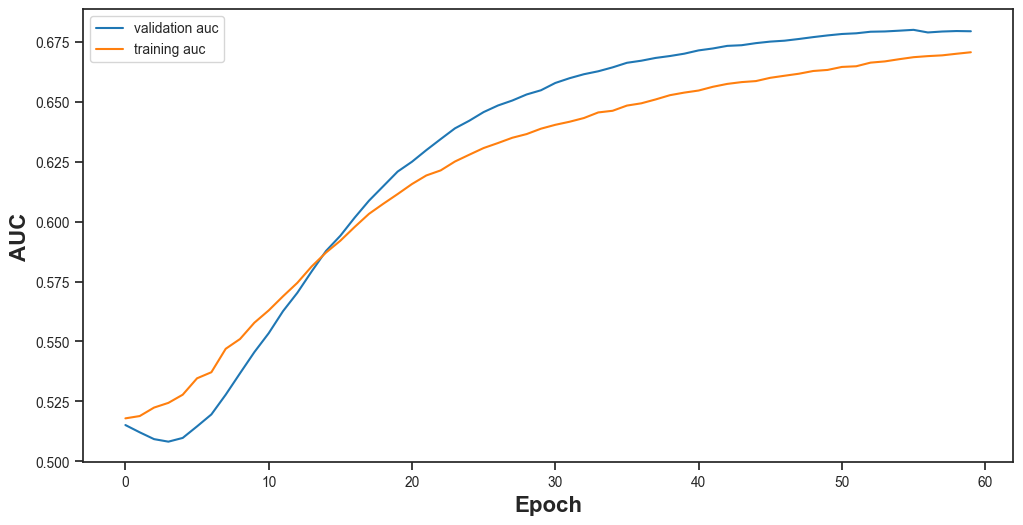

In [11]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(historia.history["val_auc"], label="validation auc")
plt.plot(historia.history["auc"], label="training auc")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("AUC", weight="bold", fontsize=16)
plt.legend()
plt.show()

## 

## Evaluo la red (con test)

In [12]:
scores = modelo.evaluate(noticias_online_test_tf_idf, noticias_online_target_test_enc)

125/125 [==============================] - 0s 460us/step - loss: 0.4260 - auc: 0.6552


In [13]:
auc = f'La {modelo.metrics_names[1]} es: {round(scores[1], 4)}'
auc

'La auc es: 0.6552'